In [1]:
import sys

## find 'bibliotheca' package
sys.path.insert(0, '..')

sys.version

'3.7.3 (default, Mar 27 2019, 09:23:15) \n[Clang 10.0.1 (clang-1001.0.46.3)]'

In [2]:
import json
import datetime
import numpy as np

import re

In [3]:
from collections import defaultdict

In [4]:
siacoin_grouping = {}

with open('../data/reddit/siacoin_grouping.json', 'r') as siacoin_grouping_json:
    siacoin_grouping = json.loads(siacoin_grouping_json.read())

In [5]:
siacoin_centrality_metrics = {}

with open('../data/reddit/siacoin_centrality_metrics.json', 'r') as siacoin_centrality_metrics_json:
    siacoin_centrality_metrics = json.loads(siacoin_centrality_metrics_json.read())

In [6]:
import spacy

from bibliotheca.networks import centrality_metrics
from bibliotheca.components import CustomComponent
from bibliotheca.utils import contractions

In [7]:
def clean_post(text: str) -> str:
    
    flags = re.IGNORECASE | re.MULTILINE
    
    text = re.sub(r'[\r\n]', ' ', text, flags = flags)
    text = re.sub(r'\b(sia|sc)\b', 'siacoin', text, flags = flags)
    
    text = re.sub(r'\[removed\]', '', text, flags = flags)
    
    text = contractions.expand_contractions(text)
    
    return text.strip().lower()

In [8]:
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

nlp.add_pipe(nlp.create_pipe("sentencizer"))

nlp.add_pipe(
    CustomComponent(nlp, clean_post),
    first = True
)

nlp.pipeline

[('custom_component',
  <bibliotheca.components.custom.CustomComponent at 0x1310251d0>),
 ('tagger', <spacy.pipeline.pipes.Tagger at 0x131062da0>),
 ('sentencizer', <spacy.pipeline.hooks.SentenceSegmenter at 0x131025198>)]

In [9]:
def get_most_influential_posts(siacoin_grouping, siacoin_centrality_metrics, stop_authors, author_limit, stop_words, debug = False, lemma = False):
    influential_authors_by_month = defaultdict(list)
    influential_text_by_month = defaultdict(list)

    for year in siacoin_grouping.keys():
        for month in siacoin_grouping[year].keys():
            key = f'{year}-{month}'
            metric_groupings = siacoin_centrality_metrics[key]
            acceptable_authors = centrality_metrics.filter_metrics(
                metric_groupings,
                stop_authors,
                author_limit
            )

            influential_authors_by_month[key] = acceptable_authors

            posts = list(siacoin_grouping[year][month].keys())
            
            if debug:
                print(key, '@', len(posts))

            for post_id in posts:
                submissions = list(filter(
                    lambda submission: acceptable_authors[submission['author']],
                    siacoin_grouping[year][month][post_id],
                ))

                for submission in submissions:
                    doc = nlp(submission['text'])

                    sents = []
                    for sent in doc.sents:
                        tokens = []
                        for token in sent:
                            word = token.text
                            
                            if lemma:
                                word = token.lemma_
                                if not word.isalpha():
                                    word = token.text
                                
                            if word.isalpha() and word not in stop_words:
                                tokens.append(word)
                                
                        sents.append(tokens)

                    if len(tokens) > 0:
                        influential_text_by_month[key].append(sents)
                        
    return {
        'authors': influential_authors_by_month,
        'texts': influential_text_by_month
    }

def create_vocab(influential_text_by_month):
    token_lookup = defaultdict(int)

    for key in influential_text_by_month.keys():
        posts = influential_text_by_month[key]
        for post in posts:
            for sent in post:
                for token in sent:
                    token_lookup[token] += 1
    
    return token_lookup

def find_bots(influential_authors_by_month):
    bots = []
    for key in influential_authors_by_month.keys():
        for author, allowed in influential_authors_by_month[key].items():
            author_to_lower = author.lower()
            if allowed and ('bot' in author_to_lower or 'messenger' in author_to_lower):
                bots.append(author)

    return bots

def find_stop_words_from_vocab(vocab: defaultdict(int), low_threshold: int, high_threshold: int):
    stop_words = []
    for token, amount in vocab.items():
        if amount < low_threshold or amount > high_threshold:
            stop_words.append(token)
            
    return stop_words

In [10]:
from nltk.corpus import stopwords

In [11]:
stop_authors = [ 'TotesMessenger' ]
stop_words = stopwords.words('english')

iteration = 1
top_authors_to_take = 10

while True:
    
    results = get_most_influential_posts(
        siacoin_grouping,
        siacoin_centrality_metrics,
        stop_authors,
        top_authors_to_take,
        [],
        False,
        False
    )

    influential_authors_by_month = results['authors']
    influential_text_by_month = results['texts']
    
    n_stop_authors = len(stop_authors)
    
    stop_authors.extend(
        find_bots(influential_authors_by_month)
    )
    stop_authors = list(set(stop_authors))
    
    if n_stop_authors == len(stop_authors):
        token_lookup = create_vocab(influential_text_by_month)
        print('complete @ iteration#', iteration)
        
        break
        
    print('finished iteration#', iteration, '(cont)')
    iteration += 1

finished iteration# 1 (cont)
complete @ iteration# 2


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

16.09609183046683
14.0


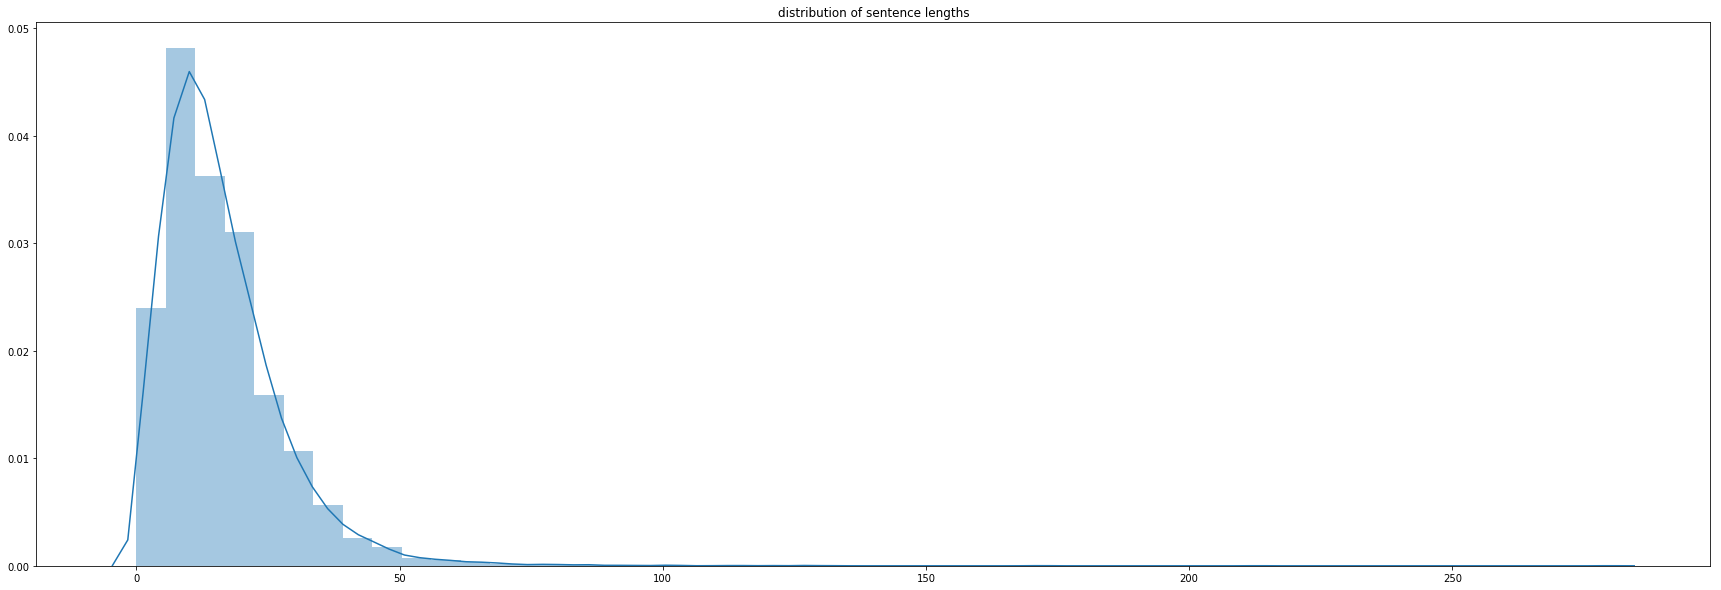

In [13]:
sentence_lengths = []

for key in influential_text_by_month:
    for post in influential_text_by_month[key]:
        sentence_lengths.extend([ len(sent) for sent in post ])

plt.figure(figsize=(30, 10))

plt.title('distribution of sentence lengths')
sns.distplot(sentence_lengths)

print(np.mean(sentence_lengths))
print(np.median(sentence_lengths))

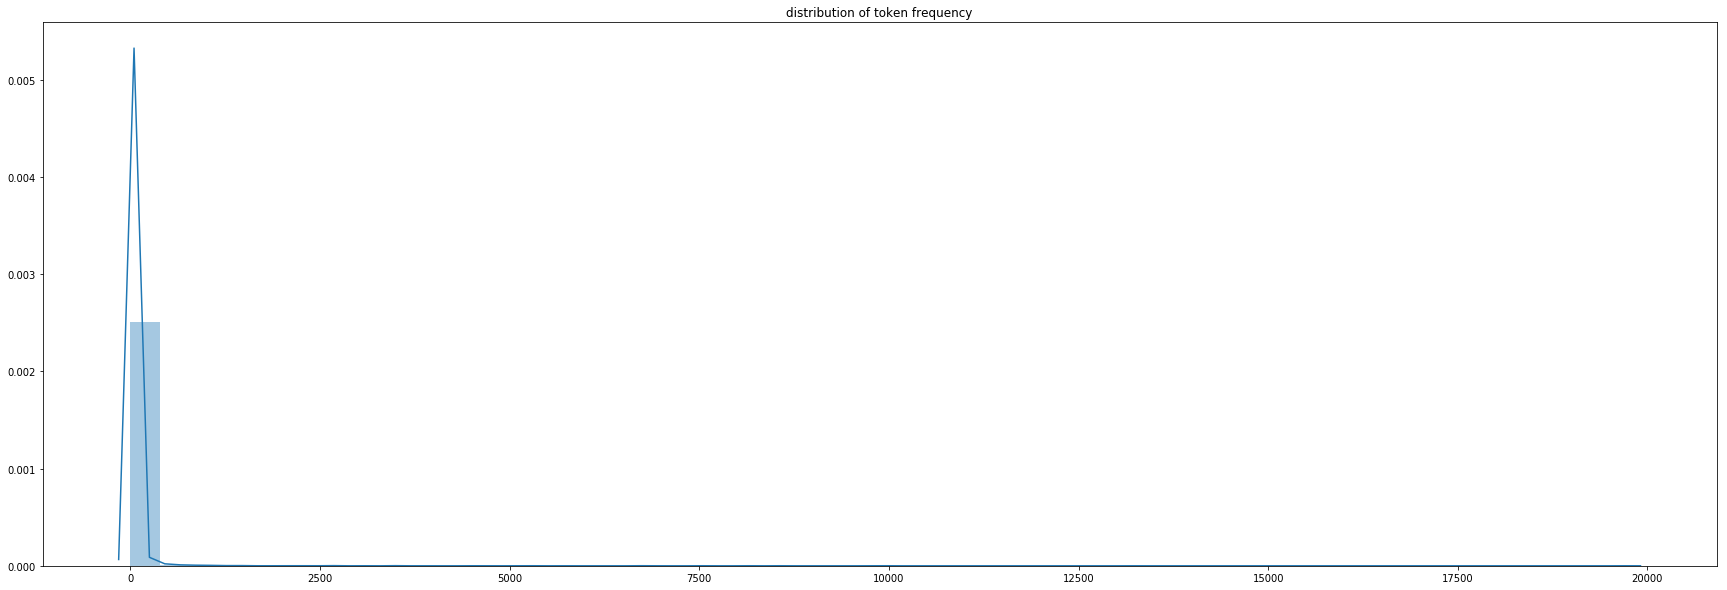

In [14]:
plt.figure(figsize=(30, 10))

plt.title('distribution of token frequency')
sns.distplot(list(token_lookup.values()))

In [15]:
limit = 10
sentence_must_be = 13

X_words = []
y_words = []

ignore_terms = []

for key in influential_text_by_month.keys():
    for posts in influential_text_by_month[key]:
        for post in posts:
            for sent in post:
                if len(sent) < sentence_must_be:
                    continue

                ## filter down low/high volume terms
                tokens = [ tk for tk in post if tk not in ignore_terms ]

                n_tokens = len(tokens)
                for i in range(limit, n_tokens):
                    X_words.append(tokens[i-limit:i])
                    y_words.append(tokens[i])
    
print('len#', len(X_words))

len# 35442


In [16]:
print(
    X_words[3],
    '\n\n'
    'target =', y_words[3]
)

['can', 'set', 'your', 'offer', 'as', 'a', 'percentage', 'of', 'the', 'current'] 

target = market


In [17]:
def get_common_vocab(X, y):
    vocab = defaultdict(int)
    
    for x in X:
        for tk in x:
            vocab[tk] += 1
    
    for tk in y:
        vocab[tk] += 1
        
    return list(vocab.keys())

vocab = get_common_vocab(X_words, y_words)

In [18]:
vocab_size = len(vocab)
word_indices = dict((tk, i) for i, tk in enumerate(vocab))
indices_word = dict((i, tk) for i, tk in enumerate(vocab))

print('vocab#', vocab_size)

vocab# 5228


In [19]:
X = []
y = []

for x in X_words:
    X.append(
        [ word_indices[tk] for tk in x ]
    )
    
for tk in y_words:
    y.append(word_indices[tk])

In [20]:
print(
    X[1],
    '\n\n'
    'target =', y[1]
)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 

target = 11


In [21]:
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding

Using TensorFlow backend.


In [22]:
X_keras = np.array(X)
y_keras = to_categorical(y, vocab_size)

seq_length = X_keras.shape[1]

In [23]:
model = Sequential()

## https://keras.io/layers/embeddings/#embeddings
model.add(
    Embedding(
        input_dim = vocab_size,
        input_length = seq_length,
        output_dim = seq_length
    )
)

## https://keras.io/layers/recurrent/
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(200))

## https://keras.io/layers/core/
model.add(Dense(200, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 10)            52280     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 200)           168800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 5228)              1050828   
Total params: 1,632,908
Trainable params: 1,632,908
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
# compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# fit model
model.fit(
    X_keras,
    y_keras,
    batch_size = 150,
    epochs = 100
)

/usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
35442/35442 [==============================] - 25s 696us/step - loss: 6.8649 - accuracy: 0.0473
Epoch 2/100
35442/35442 [==============================] - 23s 653us/step - loss: 6.5386 - accuracy: 0.0493
Epoch 3/100
35442/35442 [==============================] - 23s 640us/step - loss: 6.4423 - accuracy: 0.0496
Epoch 4/100
35442/35442 [==============================] - 23s 663us/step - loss: 6.3477 - accuracy: 0.0510
Epoch 5/100
35442/35442 [==============================] - 24s 681us/step - loss: 6.2038 - accuracy: 0.0642
Epoch 6/100
35442/35442 [==============================] - 23s 660us/step - loss: 6.0046 - accuracy: 0.0779
Epoch 7/100
35442/35442 [==============================] - 23s 647us/step - loss: 5.8481 - accuracy: 0.0867
Epoch 8/100
35442/35442 [==============================] - 24s 668us/step - loss: 5.7283 - accuracy: 0.0937
Epoch 9/100
35442/35442 [==============================] - 22s 613us/step - loss: 5.6163 - accuracy: 0.1008
Epoch 10/100
35442/35442 [==

In [25]:
loss, accuracy = model.evaluate(X_keras, y_keras, verbose=0)

print('accuracy#', accuracy, 'loss#', loss)

accuracy# 0.9707691669464111 loss# 0.15577725378882082


In [26]:
def produce_sentence(model, seed, iterations = 5):
    limit = len(seed)
    
    sentence = seed.copy()
    for iteration in range(0, iterations):
        X_new = np.array([sentence[iteration:]])
        predicted_class = model.predict_classes(X_new).tolist()
        sentence = np.append(sentence, predicted_class)
        
    return sentence

In [27]:
Xnew = np.array([ X_keras[3] ])
predicted_class = model.predict_classes(Xnew).tolist()

print([ indices_word[tk] for tk in X_keras[3] ])

print()
print(indices_word[predicted_class[0]])
print(y_words[3])

['can', 'set', 'your', 'offer', 'as', 'a', 'percentage', 'of', 'the', 'current']

market
market


In [28]:
index = np.random.randint(0, len(X_keras))
seed_text = X_keras[index]
sentence = produce_sentence(model, seed_text, 10)

[ indices_word[tk] for tk in sentence ]

['increasing',
 'price',
 'attracts',
 'people',
 'to',
 'siacoin',
 'as',
 'we',
 'will',
 'as',
 'general',
 'awareness',
 'imagine',
 'someone',
 'correlating',
 'siacoin',
 'to',
 'decentralized',
 'cloud',
 'storage']

In [29]:
with open('../data/reddit/siacoin_vocab.json', 'w') as vocab_output:
    vocab_output.write(json.dumps(vocab))

In [30]:
import os

In [31]:
if not os.path.exists('../data/reddit/models'):
    os.mkdir('../data/reddit/models')

model.save('../data/reddit/models/model.h5')